In [26]:
import numpy as np
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [24]:
mat_data = scipy.io.loadmat('DDD_001.mat')

gamma_cg = mat_data['gamma_cg']
l_bar_sys = mat_data['l_bar_sys']
rho_sys = mat_data['rho_sys']
schmid_factor = mat_data['schmid_factor']
sigma = mat_data['sigma_sys']
sigma_i = sigma * schmid_factor
time_cg = mat_data['time_cg']

np.savez('DDD_001.npz', gamma_i=gamma_cg, l_bar_i=l_bar_sys, rho_i=rho_sys, schmid_factor=schmid_factor, sigma=sigma, sigma_i=sigma_i, time=time_cg)

d = np.load('DDD_001.npz')
rho = d['rho_i'] * 10**(-10)
gamma = d['gamma_i'] * 10**(4)
sigma = d['sigma_i']
t = d['time'] * 10**6
dt = t[1] - t[0]

for i in range(12):
    globals()[f'rho{i+1}'] = rho[:, i]
    globals()[f'gamma{i+1}'] = gamma[:, i]
time = t.reshape(-1)

In [12]:
a_s = 0.3; a_gl = 0.152; a_cp =0.083; a_l = 0.326; a_h = 0.661; a_cl = 0.578
A = np.zeros ((12 , 12))

indices = {
'a_cp': [(0 ,1) ,(0,2) ,(1,2) ,(3,4) ,(3,5) ,(4,5) ,(6,7) ,(6,8) ,(7,8) ,(9 ,10) ,(9 ,11) ,(10 ,11)],
'a_cl': [(0 ,3) ,(0,7) ,(2 ,11) ,(4 ,10) ,(5,8) ,(6,9)],
'a_gl': [(0 ,4) ,(0,5) ,(0,7) ,(0 ,11) ,(1,3) ,(1,6) ,(1,8) ,(1 ,11) ,(2,3) ,(2,7) ,(2,9),(2 ,10),(3 ,8) ,(3 ,10) ,(4,8) ,(4,9) ,(4 ,11) ,(5,6) ,(5,7) ,(5 ,10) ,(6 ,10) ,(6 ,11) ,(7,9)
,(8,9)],
'a_h': [(0 ,6) ,(0,9) ,(1,4) ,(1 ,10) ,(2,5) ,(2,8) ,(3,6) ,(3,9) ,(4,7) ,(5 ,11) ,(7 ,10),(8 ,11)],
'a_l': [(0 ,8) ,(0 ,10) ,(1,5) ,(1,9) ,(2,4) ,(2,6) ,(3,7) ,(3 ,11) ,(4,6) ,(5,9) ,(7 ,11),(8 ,10)]
}

for key, ind_list in indices.items ():
    value = globals()['a_' + key.split('_')[-1]]
    for i, j in ind_list:
        A[i][j] = value
        A[j][i] = value 

np.fill_diagonal(A, a_s)

In [13]:
fnn_grads = np.load('fnn_grads.npz')

In [14]:
fnn_grads['rho_grads'].shape

(73, 12)

In [54]:
fnn_grads = np.load('fnn_grads_gp.npz')
rho_preds = fnn_grads['rho_preds']
rho_grads = fnn_grads['rho_grads']
gamma_preds = fnn_grads['gamma_preds']
gamma_grads = fnn_grads['gamma_grads']


In [95]:
time

array([5.00000000e-04, 4.03831187e-02, 8.16021034e-02, 1.27191170e-01,
       1.71037882e-01, 2.20561167e-01, 2.70952765e-01, 3.16829952e-01,
       3.67863885e-01, 4.22086422e-01, 4.68152988e-01, 5.09496126e-01,
       5.53039893e-01, 5.98634706e-01, 6.45648084e-01, 6.93576762e-01,
       7.43126710e-01, 7.87405943e-01, 8.33618431e-01, 8.83023271e-01,
       9.33936171e-01, 9.75981883e-01, 1.02409474e+00, 1.07393778e+00,
       1.12020707e+00, 1.16317274e+00, 1.20346298e+00, 1.24578565e+00,
       1.28928591e+00, 1.34071841e+00, 1.38551433e+00, 1.42808830e+00,
       1.46982841e+00, 1.51030903e+00, 1.55320065e+00, 1.59693417e+00,
       1.63720009e+00, 1.68318999e+00, 1.72392386e+00, 1.76821188e+00,
       1.81664688e+00, 1.86230356e+00, 1.91220090e+00, 1.96237586e+00,
       2.00930963e+00, 2.04645122e+00, 2.09025938e+00, 2.13088738e+00,
       2.17177144e+00, 2.20985387e+00, 2.25321030e+00, 2.29659581e+00,
       2.33613291e+00, 2.37291368e+00, 2.41277567e+00, 2.45420070e+00,
      

$$
\dot{\rho}_i = \dot{\gamma}_i \left( \frac{\tilde{c}_1}{b} \sqrt{\sum_{j=1}^{12} a'_{ij}\rho_j} - \tilde{c}_2 \rho_i \right)
$$


In [98]:
# Define the model function
def model_function(indices, gamma_dot, b, rho, constants):
    a_cp, a_cl, a_gl, a_h, a_l, a_s = constants
    c1_tilde = 10
    c2_tilde = 10
    
    # Populate the A matrix using indices and corresponding a_ values
    A = np.zeros((12, 12))
    a_values = {'cp': a_cp, 'cl': a_cl, 'gl': a_gl, 'h': a_h, 'l': a_l}
    for key, ind_list in indices.items():
        value = a_values[key.split('_')[-1]]
        for i, j in ind_list:
            A[i][j] = A[j][i] = value
    np.fill_diagonal(A, a_s)
    
    # Calculate predicted rho_dot_i for all data points
    rho_dot_predict = np.zeros_like(rho)  # ensure the shape matches
    for i in range(rho.shape[1]):  # 73
        rho_dot_predict[:, i] = gamma_dot[:, i] * ((c1_tilde / b) * np.sqrt(np.einsum('ij,j->i', A, rho[:, i])) - c2_tilde * rho[:, i])
    return rho_dot_predict

# Define the cost function to minimize
def cost_function(constants, indices, gamma_dot, b, rho, observed_rho_dot):
    predicted_rho_dot = model_function(indices, gamma_dot, b, rho, constants)
    return np.sum((observed_rho_dot - predicted_rho_dot)**2)

# Placeholders for data, replace with your actual data arrays
observed_rho_dot_i = fnn_grads['rho_grads'].T
gamma_dot_i = fnn_grads['gamma_grads'].T
b = 0.255
rho_i = fnn_grads['rho_preds'].T

# Initial guesses for constants and a_* terms
initial_constants = [0.5, 0, 0.5, 0.5, 0.5, 0.5]  # Initial guesses for c1_tilde, c2_tilde, a_cp, a_cl, a_gl, a_h, a_l, a_s

# Optimize the constants and matrix elements
result = minimize(cost_function, initial_constants, args=(indices, gamma_dot_i, b, rho_i, observed_rho_dot_i))

# Fitted constants
fitted_constants = result.x
a_cp, a_cl, a_gl, a_h, a_l, a_s = fitted_constants

/var/folders/vb/p08s7j0x2l7_sr304ry6jsn80000gn/T/ipykernel_75166/1156952140.py:19: RuntimeWarning: invalid value encountered in sqrt
  rho_dot_predict[:, i] = gamma_dot[:, i] * ((c1_tilde / b) * np.sqrt(np.einsum('ij,j->i', A, rho[:, i])) - c2_tilde * rho[:, i])
/var/folders/vb/p08s7j0x2l7_sr304ry6jsn80000gn/T/ipykernel_75166/1156952140.py:19: RuntimeWarning: invalid value encountered in sqrt
  rho_dot_predict[:, i] = gamma_dot[:, i] * ((c1_tilde / b) * np.sqrt(np.einsum('ij,j->i', A, rho[:, i])) - c2_tilde * rho[:, i])
/var/folders/vb/p08s7j0x2l7_sr304ry6jsn80000gn/T/ipykernel_75166/1156952140.py:19: RuntimeWarning: invalid value encountered in sqrt
  rho_dot_predict[:, i] = gamma_dot[:, i] * ((c1_tilde / b) * np.sqrt(np.einsum('ij,j->i', A, rho[:, i])) - c2_tilde * rho[:, i])


In [99]:
a_s_hamed = 0.3; a_gl_hamed = 0.152; a_cp_hamed =0.083; a_l_hamed = 0.326; a_h_hamed = 0.661; a_cl_hamed = 0.578

print(f"Our predicted a_s is: {a_s}. The Hamed a_s is {a_s_hamed}.")
print(f"Our predicted a_l is: {a_l}. The Hamed a_l is {a_l_hamed}.")
print(f"Our predicted a_h is: {a_h}. The Hamed a_h is {a_h_hamed}.")
print(f"Our predicted a_gl is: {a_gl}. The Hamed a_gl is {a_gl_hamed}.")
print(f"Our predicted a_cl is: {a_cl}. The Hamed a_cl is {a_cl_hamed}.")
print(f"Our predicted a_cp is: {a_cp}. The Hamed a_cp is {a_cp_hamed}.")


Our predicted a_s is: -233.25891104862714. The Hamed a_s is 0.3.
Our predicted a_l is: -357.8678842080978. The Hamed a_l is 0.326.
Our predicted a_h is: -437.8361924842504. The Hamed a_h is 0.661.
Our predicted a_gl is: -727.8491925846265. The Hamed a_gl is 0.152.
Our predicted a_cl is: -167.72804585444499. The Hamed a_cl is 0.578.
Our predicted a_cp is: -368.03459447812236. The Hamed a_cp is 0.083.


In [87]:
predicted = model_function(indices, gamma_dot_i, b, rho_i, fitted_constants)

/var/folders/vb/p08s7j0x2l7_sr304ry6jsn80000gn/T/ipykernel_75166/2830842578.py:19: RuntimeWarning: invalid value encountered in sqrt
  rho_dot_predict[:, i] = gamma_dot[:, i] * ((c1_tilde / b) * np.sqrt(np.einsum('ij,j->i', A, rho[:, i])) - c2_tilde * rho[:, i])


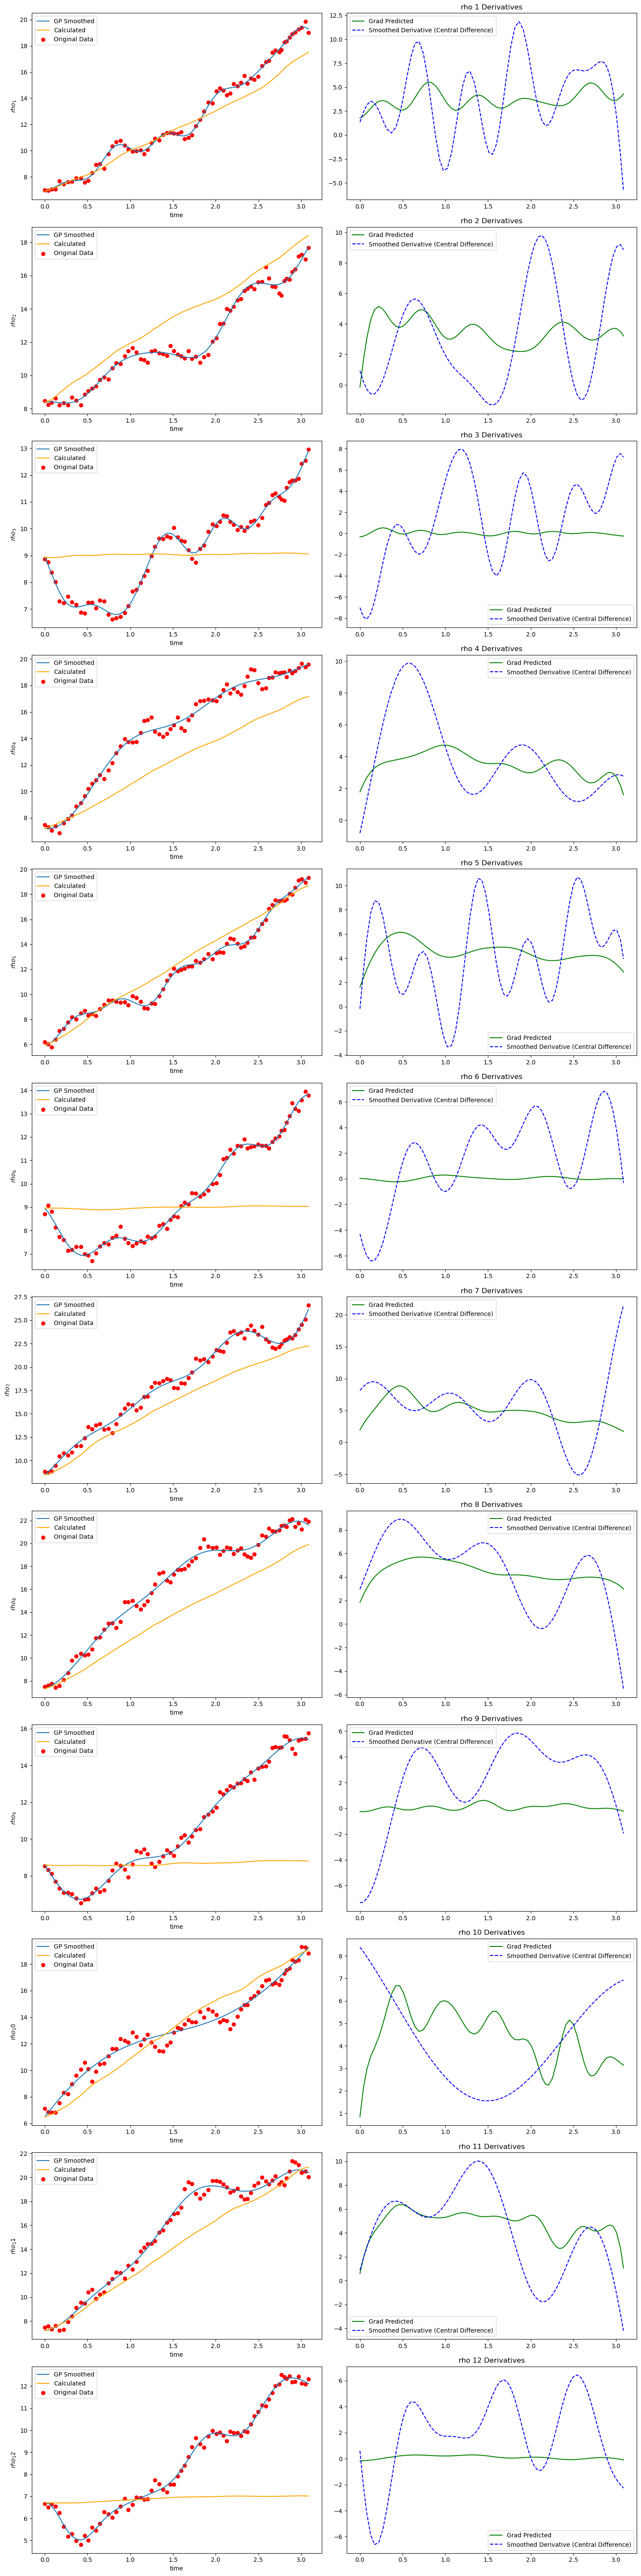

In [82]:
n_rho = 12
X = time.reshape(-1, 1)

fig, axs = plt.subplots(n_rho, 2, figsize=(15, 5 * n_rho))

for i in range(1, n_rho + 1):
    y = globals()[f'rho{i}']
    y_pred = rho_preds[:,i-1]
    grad_gp = rho_grads[:,i-1]
    grad_predicted = predicted[i-1]

    y_calc = np.array([y_pred[0]] * 73)
    for j in range(1, len(y_pred)):
        y_calc[j] = y_calc[j-1] + dt * grad_predicted[j]
    
    axs[i-1, 0].scatter(time, y, color='red', marker='o', label='Original Data')
    axs[i-1, 0].plot(time, y_pred, label="GP Smoothed")
    axs[i-1, 0].plot(time, y_calc, color = 'orange', label="Calculated")
    

    axs[i-1, 0].set_xlabel("time")
    axs[i-1, 0].set_ylabel(f"$rho_{i}$")
    axs[i-1, 0].legend()

    
    axs[i-1, 1].plot(time, grad_predicted, 'g-', label='Grad Predicted')
    axs[i-1, 1].plot(time, grad_gp, 'b--', label='Smoothed Derivative (Central Difference)')
    axs[i-1, 1].set_title(f"rho {i} Derivatives")
    axs[i-1, 1].legend()

plt.tight_layout()
plt.show()